In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="inferno")


def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

## k-means

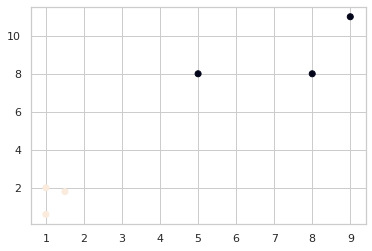

In [2]:
###k-means
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8 ],
              [8, 8],
              [1, 0.6],
              [9, 11]])

# Инициализируем центры кластеров случайными значениями из данных X
def init_centroids(X: np.ndarray, k) -> np.ndarray:
    return X[np.random.choice(X.shape[0], k)]

# Определяем функцию для присвоения каждой точке данных ближайшего центра кластера
def assign_cluster(X, centroids):
    clusters = []
    for x in X:
        distances = []
        for c in centroids:
            distances.append(euclidean_distance(x, c))
        clusters.append(np.argmin(distances))
    return clusters

# Определяем функцию для пересчета центров кластеров как среднее арифметическое всех точек данных в кластере
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        new_centroids.append(np.mean(X[np.array(clusters) == i], axis=0))
    return new_centroids

# Запускаем алгоритм k-means до тех пор, пока центры кластеров не стабилизируются или не достигнут заданного количества итераций
max_iter = 100 # максимальное количество итераций
tolerance = 0.0001 # допустимая разница между старыми и новыми центрами кластеров

def k_means(X: np.ndarray, k = 2, max_iter: int = 100, tolerance: float = 0.0001):
    centroids = init_centroids(X, k)
    for i in range(max_iter):
        clusters = assign_cluster(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        diff = np.sum([euclidean_distance(centroids[i], new_centroids[i]) for i in range(k)])
        if diff < tolerance:
            break # останавливаем алгоритм если разница меньше допустимой
        centroids = new_centroids # обновляем центры кластеров
    return clusters

clusters = k_means(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

## c-means

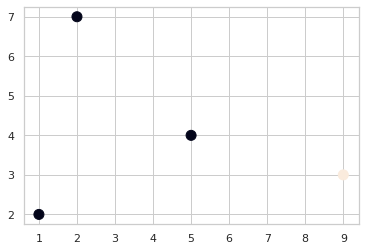

In [5]:
X = np.array([[1, 2],
              [5, 4],
              [2, 7],
              [9, 3],])

# Инициализируем матрицу принадлежности U случайными значениями из [0, 1], так что сумма по каждой строке равна единице
def init_U(X, k):
    U = np.random.rand(X.shape[0], k)
    return U / np.sum(U, axis=1)[:, None]

# Определяем функцию для вычисления центров кластеров C по формуле:
#c_j = (sum(i=1..n) u_ij^m * x_i) / (sum(i=1..n) u_ij^m)
def calculate_centroids(X, U, k, m):
    C = []
    for j in range(k):
        num = np.sum((U[:,j]**m)[:,None] * X, axis=0)
        den = np.sum(U[:,j]**m)
        C.append(num/den)
    return np.array(C)

# Определяем функцию для обновления матрицы принадлежности U по формуле:
#u_ij = 1 / (sum(h=1..k) ((||x_i - c_j|| / ||x_i - c_h||) ^ (2 / (m-1))))
def update_membership(X, C, k, m):
    U_new = []
    for i in range(X.shape[0]):
        distances = []
        for j in range(k):
            distances.append(euclidean_distance(X[i],C[j]))
        fractions = []
        for j in range(k):
            fraction = distances[j] ** (-2/(m-1))
            fraction /= sum([distances[h] ** (-2/(m-1)) for h in range(k)])
            fractions.append(fraction)
        U_new.append(fractions)
    return np.array(U_new)

# Запускаем алгоритм c-means до тех пор, пока J(U,C) не стабилизируется или не достигнет заданного порога
def c_means(X, max_iter = 100, tolerance = 0.0001, k = 2, m = 2):
    U = init_U(X, k)
    for i in range(max_iter):
        C_old = calculate_centroids(X, U, k, m)
        U_old = update_membership(X, C_old, k, m)
        C_new = calculate_centroids(X, U_old, k, m)
        diff_Csquared_summed_over_k_clusters=np.sum([euclidean_distance(C_old[j], C_new[j])**2 for j in range(k)])
        
        if diff_Csquared_summed_over_k_clusters < tolerance:
            break # останавливаем алгоритм если разница меньше допустимой
        
        U=U_old # обновляем матрицу принадлежности

    return U

U = c_means(X)

plt.scatter(X[:,0], X[:,1], c=np.argmax(U, axis=1), s=100)

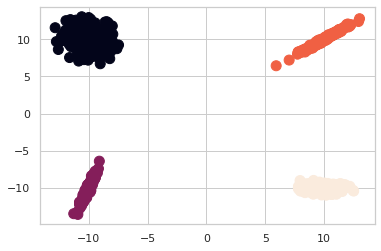

In [6]:
import sklearn.datasets as ds

plt_ind_list = np.arange(100) + 131

rand_state = 42

for class_sep,plt_ind in zip([0.1,1,10],plt_ind_list):
    x,y = ds.make_classification(n_samples=1000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=class_sep,
                                 n_redundant=0,
                                 random_state=rand_state)
    

#plt.scatter(x[:,0], x[:,1])

U = c_means(x, k=4)
plt.scatter(x[:,0], x[:,1], c=np.argmax(U, axis=1), s=100)

## Алгоритм Краскала

In [7]:
# список ребер графа (длина, вершина 1, вершина 2)
graph = [(25, 1, 2), (26, 1, 4), (15, 1, 6), (23, 2, 3), (20, 2, 5),
         (18, 2, 6), (19, 3, 4), (21, 3, 5), (12, 5, 6)]

def kruskal(graph: list) -> list:
    Rs = sorted(graph, key=lambda x: x[0])
    U = set()   # список соединенных вершин
    D = {}      # словарь списка изолированных групп вершин
    T = []      # список ребер остова

    for r in Rs:
        if r[1] not in U and r[2] not in U: # если обе вершины не соединены, то
            D[r[1]] = [r[1], r[2]]          # формируем в словаре ключ с номерами вершин
            D[r[2]] = D[r[1]]               # и связываем их с одним и тем же списком вершин

        if r[1] not in U or r[2] not in U:  # проверка для исключения циклов в остове
            if not D.get(r[1]):             # если в словаре нет первой вершины, то
                D[r[2]].append(r[1])        # добавляем в список первую вершину
                D[r[1]] = D[r[2]]           # и добавляем ключ с номером первой вершины
            else:
                D[r[1]].append(r[2])        # иначе, все то же самое делаем со второй вершиной
                D[r[2]] = D[r[1]]

            T.append(r)             # добавляем ребро в остов
            U.add(r[1])             # добавляем вершины в множество U
            U.add(r[2])

    for r in Rs:    # проходим по ребрам второй раз и объединяем разрозненные группы вершин
        if r[2] not in D[r[1]]:     # если вершины принадлежат разным группам, то объединяем
            T.append(r)             # добавляем ребро в остов
            gr1 = D[r[1]]
            D[r[1]] += D[r[2]]      # объединем списки двух групп вершин
            D[r[2]] += gr1
    
    return T

print(kruskal(graph))

[(12, 5, 6), (15, 1, 6), (18, 2, 6), (19, 3, 4), (21, 3, 5)]
